### Load packages & data imputed by MICE 

In [1]:
# general:
import pandas as pd
import numpy as np
import catboost as cat
# self-written functions:
import sys
sys.path.append("../data_process/")
import ML_func as ml
import data_cleaner as dc

In [2]:
test = dc.load_py('../../clean_data/test.pkl')   # CatBoost & light GBM use categorical
train = dc.load_py('../../clean_data/train.pkl')
test_dummy = dc.load_py('../../clean_data/test_dummy.pkl')    # XGBoost use one-hot encoding
train_dummy = dc.load_py('../../clean_data/train_dummy.pkl')
x_test_dummy = test_dummy.copy()
x_train_dummy = train_dummy.copy()
x_test_dummy.pop('progress')   
x_train_dummy.pop('progress')
x_test = test.copy()
x_train = train.copy()
y_test = x_test.pop('progress')
y_train = x_train.pop('progress')
cat_features=['PTGENDER', 'PTETHCAT', 'PTMARRY', 'PTRACCAT']

### CatBoost Final model

In [3]:
cat_grid = dc.load_py("outcomes/catboost_grid_result.pkl") # result from HPC
print(cat_grid.shape)
display(cat_grid.head() )
params_cat = ml.vote_hyperparam(cat_grid, top_n=1) # select hyperparam from top 1 model
print(params_cat)

(1320, 17)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
318,1.240625,0.083910,0.003750,0.000120,4,500,4.0,0.09,"{'depth': 4, 'iterations': 500, 'l2_leaf_reg':...",0.298544,0.342433,0.437747,0.547572,0.509527,0.427165,0.094991,1
14,0.166238,0.002102,0.003585,0.000424,3,100,1.0,0.3,"{'depth': 3, 'iterations': 100, 'l2_leaf_reg':...",0.324159,0.448398,0.285918,0.542426,0.518282,0.423837,0.102512,2
213,0.211815,0.001797,0.003454,0.000060,4,100,4.5,0.09,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",0.286721,0.397251,0.455367,0.511784,0.459873,0.422199,0.076839,3
94,0.606646,0.094162,0.003439,0.000110,3,300,3.5,0.3,"{'depth': 3, 'iterations': 300, 'l2_leaf_reg':...",0.334329,0.343914,0.376429,0.465161,0.586152,0.421197,0.094516,4
348,0.234512,0.002959,0.003531,0.000077,5,100,1.5,0.09,"{'depth': 5, 'iterations': 100, 'l2_leaf_reg':...",0.324644,0.346104,0.437747,0.488280,0.483837,0.416123,0.068601,5


{'depth': 4, 'iterations': 500, 'l2_leaf_reg': 4.0, 'learning_rate': 0.09}


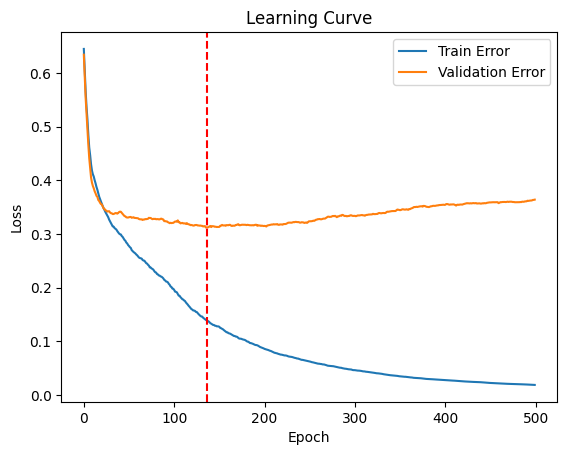

Setup: {'depth': 4, 'iterations': 500, 'l2_leaf_reg': 4.0, 'learning_rate': 0.09, 'loss_function': 'Logloss'}, 5-fold CV with stratification


In [4]:
cat_opt = ml.catboost_cv(x_train, y_train, params=params_cat, 
               cat_features=cat_features, 
               fold=5, seed=555, plotit=True)

In [5]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, cat_opt.predict(x_test) ) )
print(np.mean(y_test == cat_opt.predict(x_test)) )
print("best iteration: %s"% cat_opt.best_iteration_)

[[322  11]
 [ 15  13]]
0.9279778393351801
best iteration: 136


### XGBoost Final Model

In [6]:
xgb_grid = dc.load_py("outcomes/xgb_grid_result.pkl") # result from HPC
display(xgb_grid.head() )  # 5 & 6 model has a bigger difference 
params_xgb = ml.vote_hyperparam(xgb_grid, top_n=3) # vote params by top 5
print(params_xgb)
params_xgb['n_estimators'] = 1000  # have early stopping
params_xgb['learning_rate'] = 0.1  # learning rate=1 too high, top 2-10 have 0.1 or 0.05

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,param_subsample,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1245,0.070747,0.000537,0.003881,0.000045,0.7,1,5,100,3,0.7,hist,"{'colsample_bytree': 0.7, 'learning_rate': 1, ...",0.236383,0.444467,0.402967,0.501469,0.471026,0.411262,0.093234,1
2043,0.160127,0.002463,0.003428,0.000077,1,0.1,3,300,0,1,hist,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",0.270784,0.326922,0.465161,0.509527,0.456629,0.405805,0.090904,2
2020,0.168452,0.003391,0.003302,0.000012,1,0.1,3,100,0.1,0.7,exact,"{'colsample_bytree': 1, 'learning_rate': 0.1, ...",0.368115,0.328025,0.427144,0.455367,0.448445,0.405419,0.049395,3
512,0.357314,0.020975,0.003457,0.000008,0.7,0.05,9,100,0.5,0.7,exact,"{'colsample_bytree': 0.7, 'learning_rate': 0.0...",0.334329,0.311118,0.318647,0.542426,0.515761,0.404456,0.102389,4
649,0.086174,0.001796,0.003366,0.000078,0.7,0.1,5,100,0,0.7,hist,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.368115,0.247590,0.332993,0.542426,0.518282,0.401881,0.112244,5


{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 0, 'subsample': 0.7, 'tree_method': 'hist'}


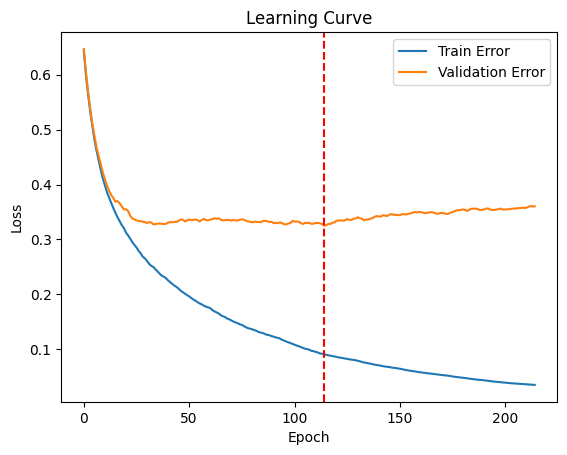

Setup: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000, 'reg_lambda': 0, 'subsample': 0.7, 'tree_method': 'hist', 'early_stopping_rounds': 100}, 5-fold CV with stratification


In [7]:
xgb_opt = ml.xgboost_cv(x_train_dummy, y_train, params_xgb,
                        fold=5, seed=555, plotit=True)
# params_xgb['learning_rate'] = 0.05  # to increase base model 
# xgb_opt = ml.xgboost_cv(x_train_dummy, y_train, params_xgb,
#                         fold=5, seed=777, plotit=True)

In [8]:
print(confusion_matrix(y_test, xgb_opt.predict(x_test_dummy) ) )
print(np.mean(y_test == xgb_opt.predict(x_test_dummy)) )
print("best iteration: %s"% xgb_opt.best_iteration)

[[319  14]
 [ 16  12]]
0.9168975069252078
best iteration: 114


### Light GBM final model

In [9]:
lgb_grid = dc.load_py("outcomes/lgb_grid_result.pkl") # result from HPC
display(lgb_grid.head() )  # 5 & 6 model has a bigger difference 
params_lgb = ml.vote_hyperparam(lgb_grid, top_n=1) # vote params by top 5
print(params_lgb)
params_lgb['n_estimators'] = 1000  # > increase iteration since will do early stopping

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_is_unbalance,param_learning_rate,param_n_estimators,param_num_leaves,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7056,0.025680,0.000846,0.003755,0.000003,1,True,0.1,100,3,4.0,0.7,"{'colsample_bytree': 1, 'is_unbalance': True, ...",0.482340,0.482148,0.495495,0.487441,0.514198,0.492324,0.011963,1
7057,0.028594,0.003033,0.003758,0.000007,1,True,0.1,100,3,4.0,1,"{'colsample_bytree': 1, 'is_unbalance': True, ...",0.482340,0.482148,0.495495,0.487441,0.514198,0.492324,0.011963,1
7054,0.025788,0.000456,0.003760,0.000004,1,True,0.1,100,3,3.5,0.7,"{'colsample_bytree': 1, 'is_unbalance': True, ...",0.447790,0.482148,0.495495,0.512051,0.508558,0.489208,0.023242,3
7055,0.025996,0.001056,0.003761,0.000005,1,True,0.1,100,3,3.5,1,"{'colsample_bytree': 1, 'is_unbalance': True, ...",0.447790,0.482148,0.495495,0.512051,0.508558,0.489208,0.023242,3
7051,0.025700,0.001860,0.003760,0.000016,1,True,0.1,100,3,2.5,1,"{'colsample_bytree': 1, 'is_unbalance': True, ...",0.470464,0.473257,0.471436,0.479527,0.537791,0.486495,0.025841,5


{'colsample_bytree': 1, 'is_unbalance': True, 'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 3, 'reg_lambda': 4.0, 'subsample': 0.7}


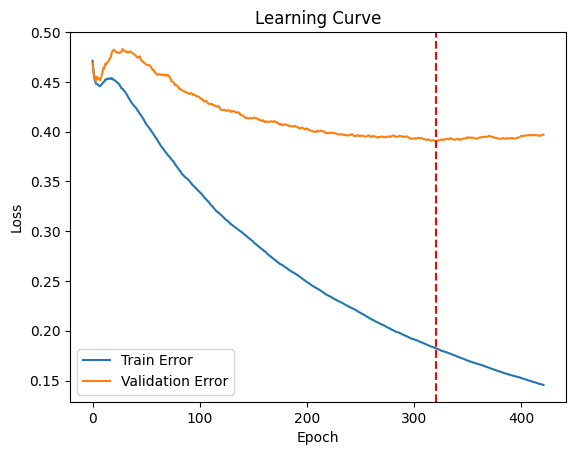

Setup: {'colsample_bytree': 1, 'is_unbalance': True, 'learning_rate': 0.1, 'n_estimators': 1000, 'num_leaves': 3, 'reg_lambda': 4.0, 'subsample': 0.7, 'early_stopping_round': 100}, 5-fold CV with stratification


In [10]:
lgb_opt = ml.lightgbm_cv(x_train, y_train, params_lgb, 
                         cat_features=cat_features, fold=5, seed=555, plotit=True)

In [11]:
x_test_lgb = x_test.copy()         # change dtypes for categorical features
for c in cat_features:
    x_test_lgb[c] = x_test_lgb[c].astype('category')
print(confusion_matrix(y_test, lgb_opt.predict(x_test_lgb) ) )
print(np.mean(y_test == lgb_opt.predict(x_test_lgb)) )
print("best iteration: %s"% lgb_opt.best_iteration_)

[[302  31]
 [ 11  17]]
0.8836565096952909
best iteration: 322


### Save final models
- for explainable AI & evaluation

In [12]:
dc.save_py(lgb_opt, 'models/LightGBM_optimal')
dc.save_py(cat_opt, 'models/CatBoost_optimal')
dc.save_py(xgb_opt, 'models/XGBoost_optimal')